# Compare celltype - consensus time group specific markers in WT ground tissue to scr and shr muatnt layers

#### Working directory should contain integrated Seurat object of WT and mutants, which is available on GEO under record GSE152766:

    rc.integrated_wt_shr_scr.rds
    
#### Working directory must contain subdirectories,supp_data

#### supp_data/ should contain the files, which are available on Github (github.com/Hsu-Che-Wei/COPILOT):

    features.tsv.gz

#### The file 'Benfey_single_cell-Samples.csv' contains the meta data of samples, which is not provided. But one can find an example of such file in Supplementary Dataset 1 (This study)

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [2]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(ggrepel)
library(future)
#for 300gb ram 
options(future.globals.maxSize = 300000 * 1024^2)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageSt

In [4]:
rc.integrated <- readRDS("./rc.integrated_wt_shr_scr.rds")

In [5]:
feature_names <- read_tsv("./supp_data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  AGI = col_character(),
  Name = col_character(),
  Type = col_character()
)




In [13]:
  bscs <- read.csv("./Benfey_single_cell-Samples.csv", na.strings=c("","NA"), stringsAsFactors = F)
  bscs <- bscs %>% select(c('sample','name','source','geno', 'genotype','transgene','treatment','age','timepoint','rep','target_cells','date','seq_run'))
  bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)
  bscs$target_cells <- prettyNum(bscs$target_cells, big.mark = ',')

orig.idents <- data.frame(sample=rc.integrated$orig.ident)

bscs %>% filter(sample %in% orig.idents$sample)

orig.idents_info <- left_join(orig.idents, bscs, by="sample")

sample,name,source,geno,genotype,transgene,treatment,age,timepoint,rep,target_cells,date,seq_run
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_20,WT Col-0_RS1,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Shahan_6177
sc_21,WT Col-0_RS2,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Shahan_6177
sc_25,scr-4_1,Benfey lab,scr-4,scr-4 (Ws backcrossed to Col?),NA,Untreated,5_day,NA,NA,"10,000",NA,Shahan_6177
sc_30,WT Col-0_RS3,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4)
sc_31,WT Col-0_RS4,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4)
sc_36,scr_4_2,Benfey lab,scr-4,scr-4,NA,Untreated,5_day,NA,NA,"10,000",NA,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4)
sc_51,WT Col (RS_5),Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2020-02-24,Nolan_6226
sc_52,shr-2,Benfey lab,shr-2,shr-2,NA,Untreated,5_day,NA,NA,"10,000",2020-02-24,Nolan_6226


In [14]:
treatment <- orig.idents_info$treatment
names(treatment) <- colnames(rc.integrated)
head(treatment)
rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = treatment,
  col.name = 'treatment')


timepoint <- orig.idents_info$timepoint
names(timepoint) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = timepoint,
  col.name = 'timepoint')



age <- orig.idents_info$age
names(age) <- colnames(rc.integrated)
rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = age,
  col.name = 'age')



rep <- orig.idents_info$rep
names(rep) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = rep,
  col.name = 'rep')

date <- orig.idents_info$date
names(date) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = date,
  col.name = 'date')

geno <- orig.idents_info$geno

names(geno) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = geno,
  col.name = 'geno')

AAACCCAAGCCATTCA_1 AAACCCAAGCTGTTCA_1 AAACCCAAGGCGAACT_1 AAACCCACACCAGCCA_1 
       "Untreated"        "Untreated"        "Untreated"        "Untreated" 
AAACCCACACTGGCGT_1 AAACCCACAGACCTGC_1 
       "Untreated"        "Untreated"

In [15]:
rc.integrated$geno_trt <- rep("WT")
rc.integrated$geno_trt[rc.integrated$geno=="WT"] <- "WT"
rc.integrated$geno_trt[rc.integrated$geno=="shr-2"] <- "shr"
rc.integrated$geno_trt[rc.integrated$geno=="scr-4"] <- "scr"
rc.integrated$geno_trt <- factor(rc.integrated$geno_trt, levels=c("WT", "shr", "scr"))

In [18]:
table(rc.integrated$geno_trt)


   WT   shr   scr 
57906 14612 13742 

In [22]:
#subsampling
rc.integrated <- subset(rc.integrated, cells = colnames(rc.integrated)[sort(c(sample(which(rc.integrated$geno_trt=="WT"),10000,replace=FALSE),sample(which(rc.integrated$geno_trt=="shr"),10000,replace=FALSE),sample(which(rc.integrated$geno_trt=="scr"),10000,replace=FALSE)))])

In [23]:
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Metaphloem & Companion Cell","Protophloem", "Xylem", "Procambium","Xylem Pole Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))])
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]

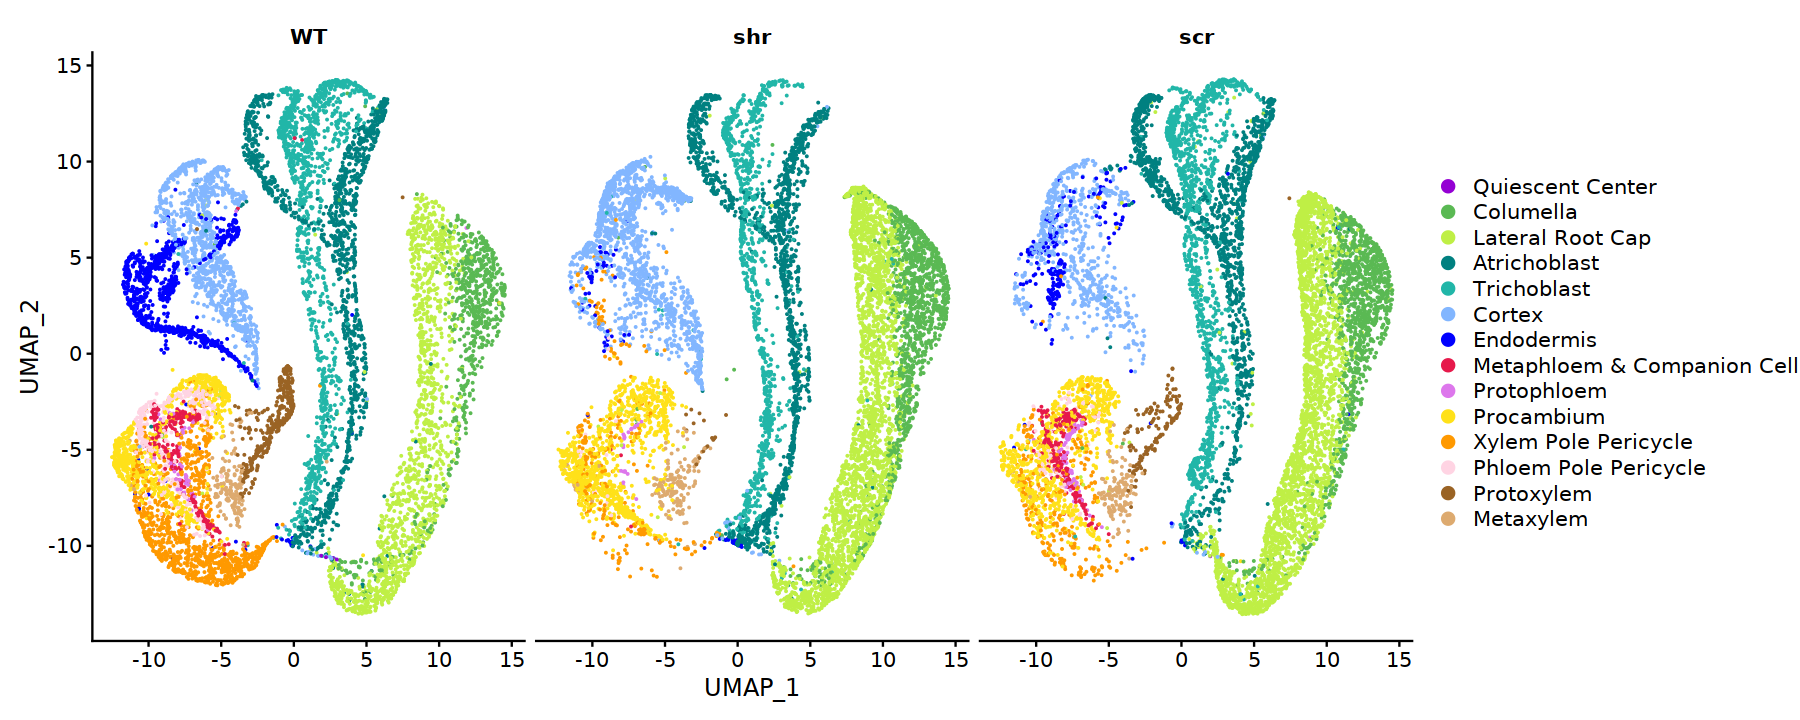

In [24]:
options(repr.plot.width=15, repr.plot.height=6)
DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color, split.by = "geno_trt")

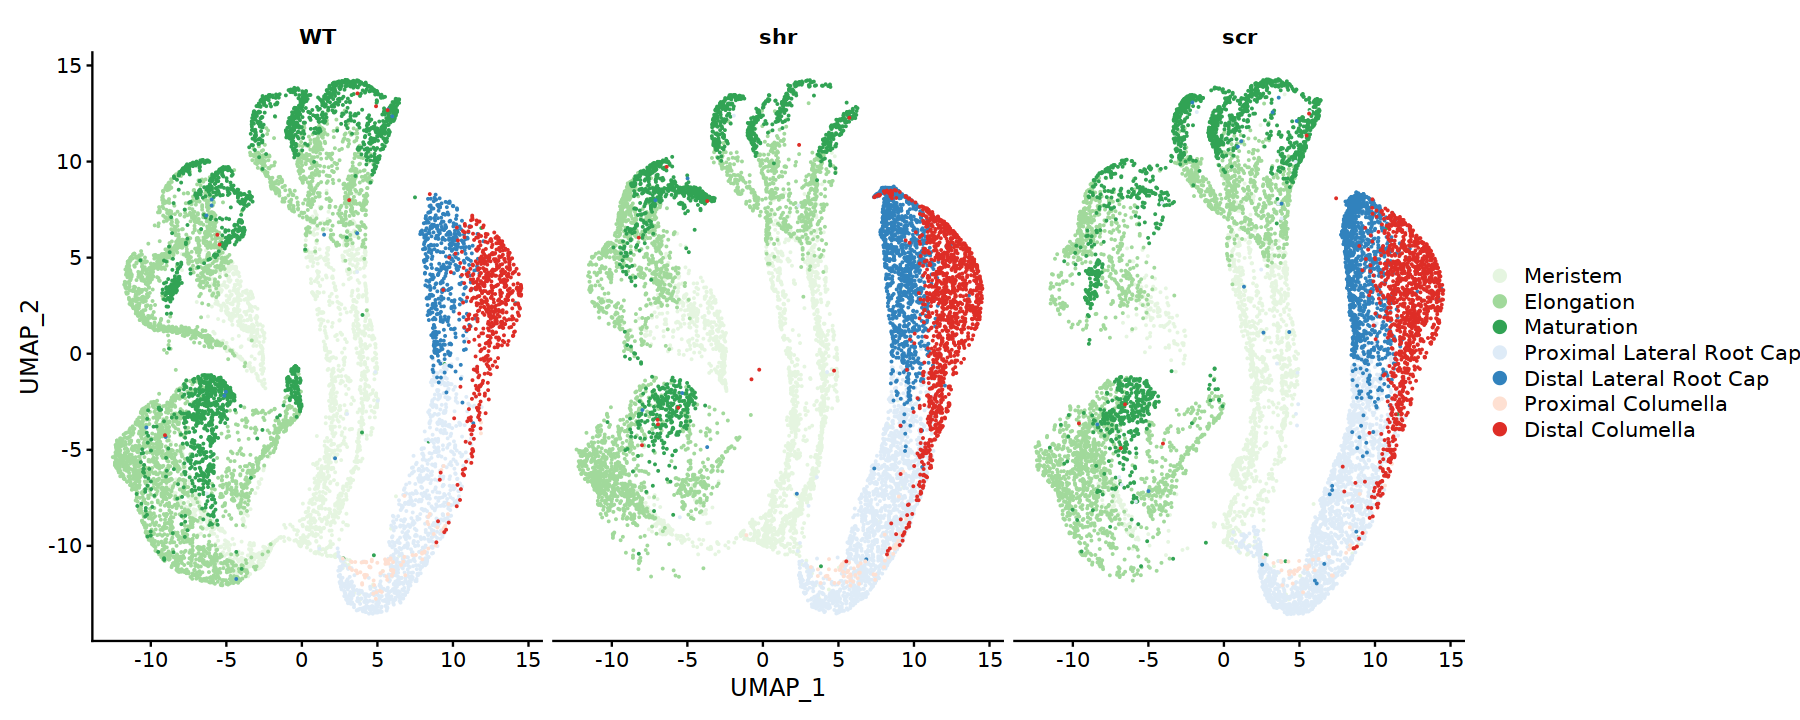

In [122]:
options(repr.plot.width=15, repr.plot.height=6)
DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno", order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation","Meristem"),cols = c("#e5f5e0", "#a1d99b", "#31a354", "#deebf7", "#3182bd", '#fee0d2','#de2d26'), split.by = "geno_trt")

In [36]:
# from WT endo/cortex enrichment and heatmap
(genes_to_plt_endo <- read.csv("./supp_data/consensus_time_endo_to_plot.csv"))

genes_to_plt_endo <- genes_to_plt_endo$x

x
<chr>
AT2G15300
AT1G71740
AT3G11550
AT2G39430
AT5G06200
AT5G65020
AT2G28671
AT1G44970
AT5G44790


In [37]:
# subset for endodermis
Endo_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Endodermis") & geno_trt=="WT")

In [38]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(Endo_QC@assays$SCT@data)
  pooled_endo <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Endo_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Endo_QC@meta.data$consensus.time.group==i)]
    pooled_endo <- cbind(pooled_endo, rowSums(m)/ncol(m))
  }



In [39]:
colnames(pooled_endo) <- unique(Endo_QC@meta.data$consensus.time.group)

In [40]:
pooled_endo

,T5,T2,T8,T4,T3,T1,T6,T9,T0,T7
AT1G01010,0.544683556,0.131227153,0.174924742,0.240088934,0.132273631,0.15694461,0.43714018,0.102163184,0.08154673,0.46848859
AT1G01020,0.086434737,0.082237801,0.100072660,0.105466239,0.066616480,0.19804205,0.09213792,0.019388732,0.32618691,0.12377628
AT1G01030,0.078174494,0.073925689,0.037132885,0.102826953,0.072285093,0.09902103,0.09472965,0.000000000,0.00000000,0.00000000
AT1G01040,0.088597760,0.044555046,0.129965096,0.080029645,0.077116764,0.00000000,0.07599594,0.004847183,0.08154673,0.11350192
AT1G01050,0.393052463,0.672196368,0.280134582,0.497448512,0.609511026,1.34877887,0.36775657,0.510989661,1.05924746,0.37699331
AT1G01060,0.178966693,0.136103120,0.129965096,0.186576462,0.205194571,0.09902103,0.22810179,0.125575442,0.04077336,0.13825718
AT1G01070,0.000000000,0.005874129,0.006188814,0.000000000,0.000000000,0.15694461,0.00000000,0.009694366,0.00000000,0.00000000
AT1G01080,0.020846532,0.017622386,0.000000000,0.041874754,0.027316145,0.00000000,0.01248914,0.000000000,0.00000000,0.02475526
AT1G01090,0.314077300,0.939359264,0.202248589,0.393799429,0.608057928,1.51940792,0.31541178,0.281690591,0.86557034,0.12798282
AT1G01100,0.275739779,0.783543270,0.289731866,0.396221131,0.541664206,2.93968553,0.36903134,0.437378376,2.65696051,0.24148474


In [41]:
(endo_sub_m <- pooled_endo[genes_to_plt_endo, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])
WT_endo <- endo_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT2G15300,0.00000000,0.00000000,0.011748257,0.003414518,0.02279731,0.06342518,0.10827989,0.08874667,0.405299327,0.864312717
AT1G71740,0.13544618,0.00000000,0.017622386,0.008826401,0.02199904,0.02389514,0.05832334,0.41897807,1.515579464,2.815233197
AT3G11550,0.20743297,0.00000000,0.036242933,0.043551795,0.05723234,0.06321337,0.13325817,1.33927045,2.765339557,3.362207725
AT2G39430,0.15523867,0.00000000,0.028823707,0.060624385,0.08349106,0.12667204,0.32944171,1.03414508,2.412335664,3.305349646
AT5G06200,0.10539762,0.00000000,0.005874129,0.019650168,0.03551561,0.07863032,0.23730380,0.85475016,1.661837958,2.764357761
AT5G65020,0.91327212,0.72502483,1.308910625,1.273376088,1.30473763,1.58871368,1.90380737,2.26892215,2.480424538,2.388414895
AT2G28671,0.00000000,0.00000000,0.000000000,0.005411883,0.04187475,0.09164637,0.11605508,0.22279731,0.690579124,0.601511928
AT1G44970,0.09467282,0.00000000,0.015184402,0.031310875,0.07103121,0.08210869,0.22751830,0.52596851,1.368137651,1.970868723
AT5G44790,0.34624141,0.25596564,0.309005674,0.233554310,0.26910091,0.64402000,0.88915979,0.93338155,1.471035216,1.855152277
AT4G34050,0.81767293,1.53106220,2.200042837,2.324994562,2.69656980,3.29781144,3.55384605,2.61706134,2.833290011,3.885013246


In [42]:
# quantile normalize

mat = endo_sub_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

In [43]:
# side annotation with color to match umap

endo_sa = rowAnnotation(foo = anno_block(gp = gpar(fill = "#0000FF"),
        labels = c("Endodermis"), 
        labels_gp = gpar(col = "white", fontsize = 18)))

In [44]:
feature_names <- read_tsv("./supp_data/features.tsv.gz", col_names = c("gene", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  gene = col_character(),
  Name = col_character(),
  Type = col_character()
)




In [45]:
# genes to mark on side of heatmap

(endo_mat_for_mark <- data.frame(mat2) %>% 
 rownames_to_column("gene") %>%
 left_join(feature_names) %>% 
 mutate(index=dplyr::row_number()) %>%
select(Name, index) %>%
filter(Name %in% c("XTH16", "SCR", "MYB36", "CASP1", "CASP2", "CASP3", "CASP4")))

Joining, by = "gene"



Name,index
<chr>,<int>
CASP2,3
CASP4,5
CASP3,11
MYB36,35
SCR,59
XTH16,61


In [46]:
# at - index of genes you want to mark
# labels - Names to show

endo_mark_anno = rowAnnotation(foo = anno_mark(at = endo_mat_for_mark$index, labels = endo_mat_for_mark$Name, labels_gp = gpar(col = "black", fontsize = 16)))

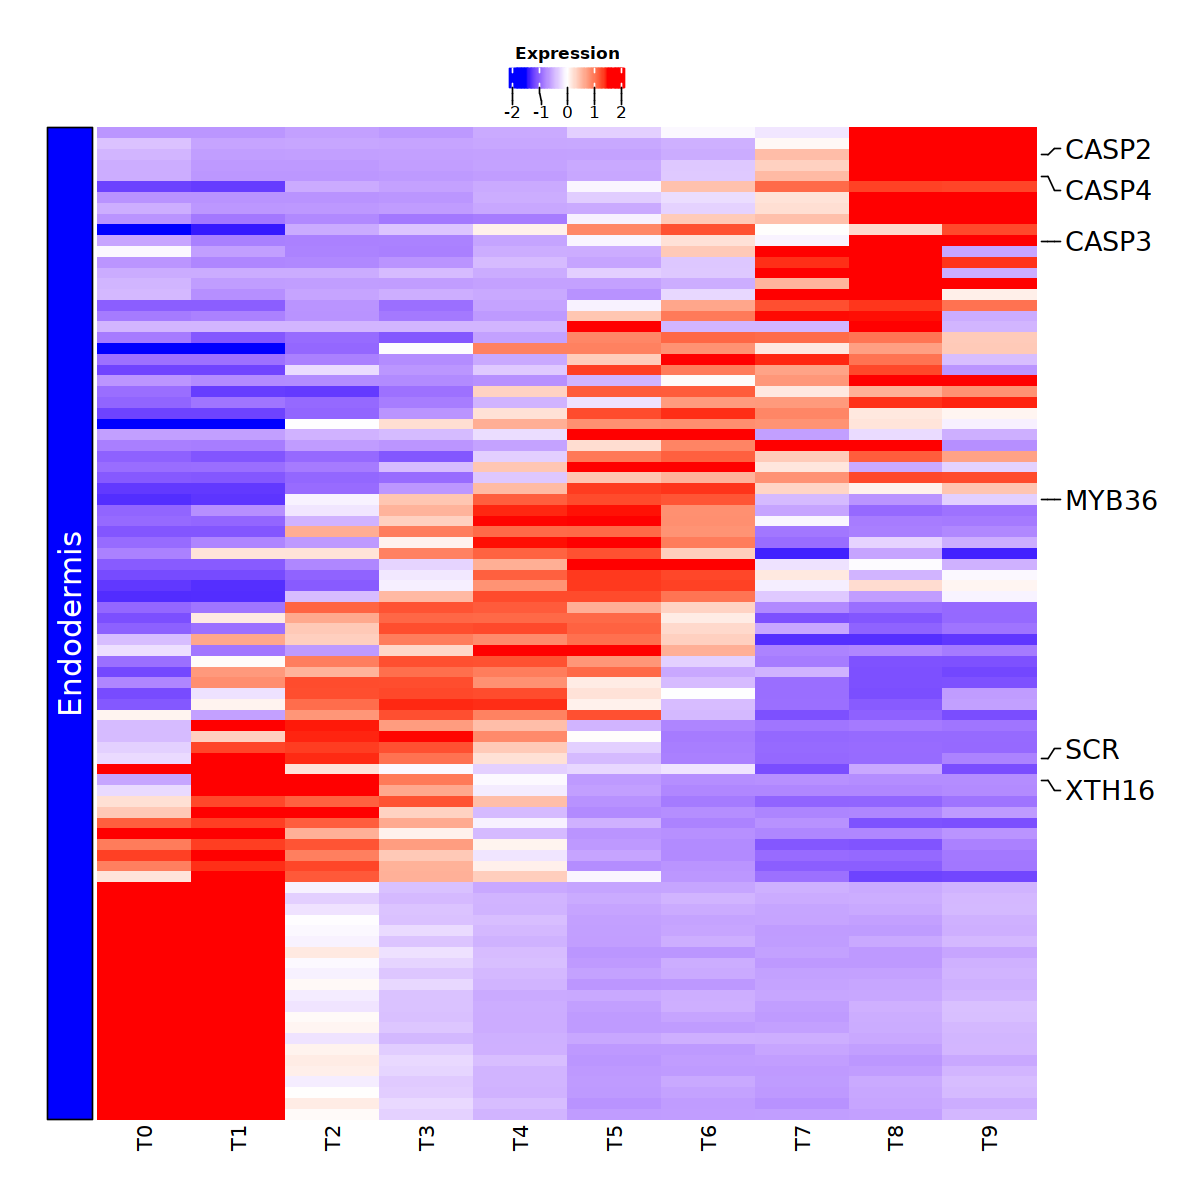

In [47]:
options(repr.plot.width=10, repr.plot.height=10)
Endo_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-1.5, 0, 1.5), 
                         c('blue','white','red')), 
                show_column_names = T,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
                   left_annotation=endo_sa,
                   right_annotation=endo_mark_anno,
               heatmap_legend_param = list(title_position="topcenter", title = "Expression", direction="horizontal"))

draw(Endo_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")


In [20]:
# do the same for shr and scr - matrix combined with all three before normalizing gene expression 

In [48]:
# subset for mutant layer
Endo_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Endodermis", "Cortex") & geno_trt=="shr")

In [49]:
Endo_QC

An object of class Seurat 
160595 features across 1731 samples within 7 assays 
Active assay: integrated (17978 features, 17978 variable features)
 6 other assays present: RNA, SCT, spliced_RNA, unspliced_RNA, spliced_SCT, unspliced_SCT
 5 dimensional reductions calculated: pca, umap, umap_50, umap_3D, umap_2D

In [50]:
table(Endo_QC$consensus.time.group)


 T0  T1  T2  T3  T4  T5  T6  T7  T8  T9 
 56  41 102 113 176  97 308 149 606  83 

In [51]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(Endo_QC@assays$SCT@data)
  pooled_endo <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Endo_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Endo_QC@meta.data$consensus.time.group==i)]
    pooled_endo <- cbind(pooled_endo, rowSums(m)/ncol(m))
  }



In [52]:
colnames(pooled_endo) <- unique(Endo_QC@meta.data$consensus.time.group)

In [53]:
(endo_sub_m <- pooled_endo[genes_to_plt_endo, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

colnames(endo_sub_m) <- c("shr_T0", "shr_T1", "shr_T2", "shr_T3", "shr_T4", "shr_T5", "shr_T6", "shr_T7", "shr_T8", "shr_T9")
shr_endo_m <- endo_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT2G15300,0.01237763,0.01690603,0.000000000,0.000000000,0.011815009,0.000000000,0.008067879,0.000000000,0.007531928,0.016702342
AT1G71740,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.012562427,0.008351171
AT3G11550,0.00000000,0.01690603,0.006795561,0.006134046,0.000000000,0.007145847,0.002250478,0.000000000,0.016822384,0.008351171
AT2G39430,0.00000000,0.00000000,0.000000000,0.000000000,0.007876673,0.028583389,0.006751434,0.004651995,0.012141182,0.000000000
AT5G06200,0.01237763,0.00000000,0.000000000,0.000000000,0.003938336,0.011325900,0.002250478,0.000000000,0.012141182,0.000000000
AT5G65020,0.79880362,1.02392764,0.885562607,0.974874611,0.705272765,0.559537446,0.446683546,0.607777222,0.522143456,0.229738831
AT2G28671,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.023737991,0.000000000,0.000000000,0.002287614,0.000000000
AT1G44970,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.022651800,0.000000000,0.000000000,0.006862843,0.000000000
AT5G44790,0.30126961,0.34229198,0.471970977,0.405899340,0.262613492,0.335155187,0.255664440,0.309334883,0.391619718,0.465632188
AT4G34050,0.84314385,1.47687357,1.673249250,1.704126550,1.983290281,2.213554980,2.110718268,2.730062871,3.078026806,2.057004359


In [54]:
# subset for mutant layer
Endo_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Endodermis", "Cortex") & geno_trt=="scr")

In [55]:
Endo_QC

An object of class Seurat 
160595 features across 952 samples within 7 assays 
Active assay: integrated (17978 features, 17978 variable features)
 6 other assays present: RNA, SCT, spliced_RNA, unspliced_RNA, spliced_SCT, unspliced_SCT
 5 dimensional reductions calculated: pca, umap, umap_50, umap_3D, umap_2D

In [56]:
table(Endo_QC$consensus.time.group)


 T0  T1  T2  T3  T4  T5  T6  T7  T8  T9 
 13   1  19  22  30 112 169 100 327 159 

In [62]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(Endo_QC@assays$SCT@data)
  pooled_endo <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Endo_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Endo_QC@meta.data$consensus.time.group==i)]
      if(length(which(Endo_QC@meta.data$consensus.time.group==i))>1){
        pooled_endo <- cbind(pooled_endo, rowSums(m)/ncol(m))          
      } else {
        pooled_endo <- cbind(pooled_endo, m)   
      }

  }



In [63]:
colnames(pooled_endo) <- unique(Endo_QC@meta.data$consensus.time.group)

In [64]:
(endo_sub_m <- pooled_endo[genes_to_plt_endo, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

colnames(endo_sub_m) <- c("scr_T0", "scr_T1", "scr_T2", "scr_T3", "scr_T4", "scr_T5", "scr_T6", "scr_T7", "scr_T8", "scr_T9")
scr_endo_m <- endo_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT2G15300,0.00000000,0.000000,0.00000000,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.007599103,0.675928288
AT1G71740,0.00000000,0.000000,0.00000000,0.00000000,0.00000000,0.015997852,0.000000000,0.020794415,0.188632456,2.952243695
AT3G11550,0.00000000,0.000000,0.00000000,0.06301338,0.00000000,0.026747610,0.012304388,0.013862944,0.407795654,3.132977385
AT2G39430,0.00000000,0.000000,0.00000000,0.00000000,0.00000000,0.022186667,0.004101463,0.020794415,0.305384527,3.062250249
AT5G06200,0.00000000,0.000000,0.00000000,0.03150669,0.00000000,0.015997852,0.015615724,0.078320142,0.370908729,2.828495476
AT5G65020,1.24054333,1.609438,1.18260633,1.31968287,0.97180440,0.995778136,0.766551413,0.910381350,0.991531321,1.997265026
AT2G28671,0.00000000,0.000000,0.00000000,0.00000000,0.00000000,0.000000000,0.004101463,0.027725887,0.076673425,0.853102040
AT1G44970,0.00000000,0.000000,0.00000000,0.00000000,0.00000000,0.015997852,0.000000000,0.000000000,0.172598746,1.894928766
AT5G44790,0.54914362,1.609438,0.64069573,0.65633801,0.28511107,0.552605206,0.574231475,0.681143594,0.910192222,2.107682521
AT4G34050,0.61273427,1.386294,2.49079486,2.27726561,2.61184089,2.553331714,2.975592644,3.387154445,3.555241954,4.123437384


In [65]:
combined_endo_m <- cbind(WT_endo, scr_endo_m, shr_endo_m)

In [66]:
combined_endo_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,⋯,shr_T0,shr_T1,shr_T2,shr_T3,shr_T4,shr_T5,shr_T6,shr_T7,shr_T8,shr_T9
AT2G15300,0.00000000,0.00000000,0.011748257,0.003414518,0.02279731,0.06342518,0.10827989,0.08874667,0.405299327,0.864312717,⋯,0.01237763,0.01690603,0.000000000,0.000000000,0.011815009,0.000000000,0.008067879,0.000000000,0.007531928,0.016702342
AT1G71740,0.13544618,0.00000000,0.017622386,0.008826401,0.02199904,0.02389514,0.05832334,0.41897807,1.515579464,2.815233197,⋯,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.012562427,0.008351171
AT3G11550,0.20743297,0.00000000,0.036242933,0.043551795,0.05723234,0.06321337,0.13325817,1.33927045,2.765339557,3.362207725,⋯,0.00000000,0.01690603,0.006795561,0.006134046,0.000000000,0.007145847,0.002250478,0.000000000,0.016822384,0.008351171
AT2G39430,0.15523867,0.00000000,0.028823707,0.060624385,0.08349106,0.12667204,0.32944171,1.03414508,2.412335664,3.305349646,⋯,0.00000000,0.00000000,0.000000000,0.000000000,0.007876673,0.028583389,0.006751434,0.004651995,0.012141182,0.000000000
AT5G06200,0.10539762,0.00000000,0.005874129,0.019650168,0.03551561,0.07863032,0.23730380,0.85475016,1.661837958,2.764357761,⋯,0.01237763,0.00000000,0.000000000,0.000000000,0.003938336,0.011325900,0.002250478,0.000000000,0.012141182,0.000000000
AT5G65020,0.91327212,0.72502483,1.308910625,1.273376088,1.30473763,1.58871368,1.90380737,2.26892215,2.480424538,2.388414895,⋯,0.79880362,1.02392764,0.885562607,0.974874611,0.705272765,0.559537446,0.446683546,0.607777222,0.522143456,0.229738831
AT2G28671,0.00000000,0.00000000,0.000000000,0.005411883,0.04187475,0.09164637,0.11605508,0.22279731,0.690579124,0.601511928,⋯,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.023737991,0.000000000,0.000000000,0.002287614,0.000000000
AT1G44970,0.09467282,0.00000000,0.015184402,0.031310875,0.07103121,0.08210869,0.22751830,0.52596851,1.368137651,1.970868723,⋯,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.022651800,0.000000000,0.000000000,0.006862843,0.000000000
AT5G44790,0.34624141,0.25596564,0.309005674,0.233554310,0.26910091,0.64402000,0.88915979,0.93338155,1.471035216,1.855152277,⋯,0.30126961,0.34229198,0.471970977,0.405899340,0.262613492,0.335155187,0.255664440,0.309334883,0.391619718,0.465632188
AT4G34050,0.81767293,1.53106220,2.200042837,2.324994562,2.69656980,3.29781144,3.55384605,2.61706134,2.833290011,3.885013246,⋯,0.84314385,1.47687357,1.673249250,1.704126550,1.983290281,2.213554980,2.110718268,2.730062871,3.078026806,2.057004359


In [67]:
# quantile normalize

mat = combined_endo_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

In [68]:
# side annotation with color to match umap

endo_sa = rowAnnotation(foo = anno_block(gp = gpar(fill = "#0000FF"),
        labels = c("Endodermis"), 
        labels_gp = gpar(col = "white", fontsize = 18)))

In [69]:
# genes to mark on side of heatmap

(endo_mat_for_mark <- data.frame(mat2) %>% 
 rownames_to_column("gene") %>%
 left_join(feature_names) %>% 
 mutate(index=dplyr::row_number()) %>%
select(Name, index) %>%
filter(Name %in% c("XTH16", "SCR", "MYB36", "CASP1", "CASP2", "CASP3", "CASP4")))

Joining, by = "gene"



Name,index
<chr>,<int>
CASP2,3
CASP4,5
CASP3,11
MYB36,35
SCR,59
XTH16,61


In [70]:
# at - index of genes you want to mark
# labels - Names to show

endo_mark_anno = rowAnnotation(foo = anno_mark(at = endo_mat_for_mark$index, labels = endo_mat_for_mark$Name, labels_gp = gpar(col = "black", fontsize = 16)))

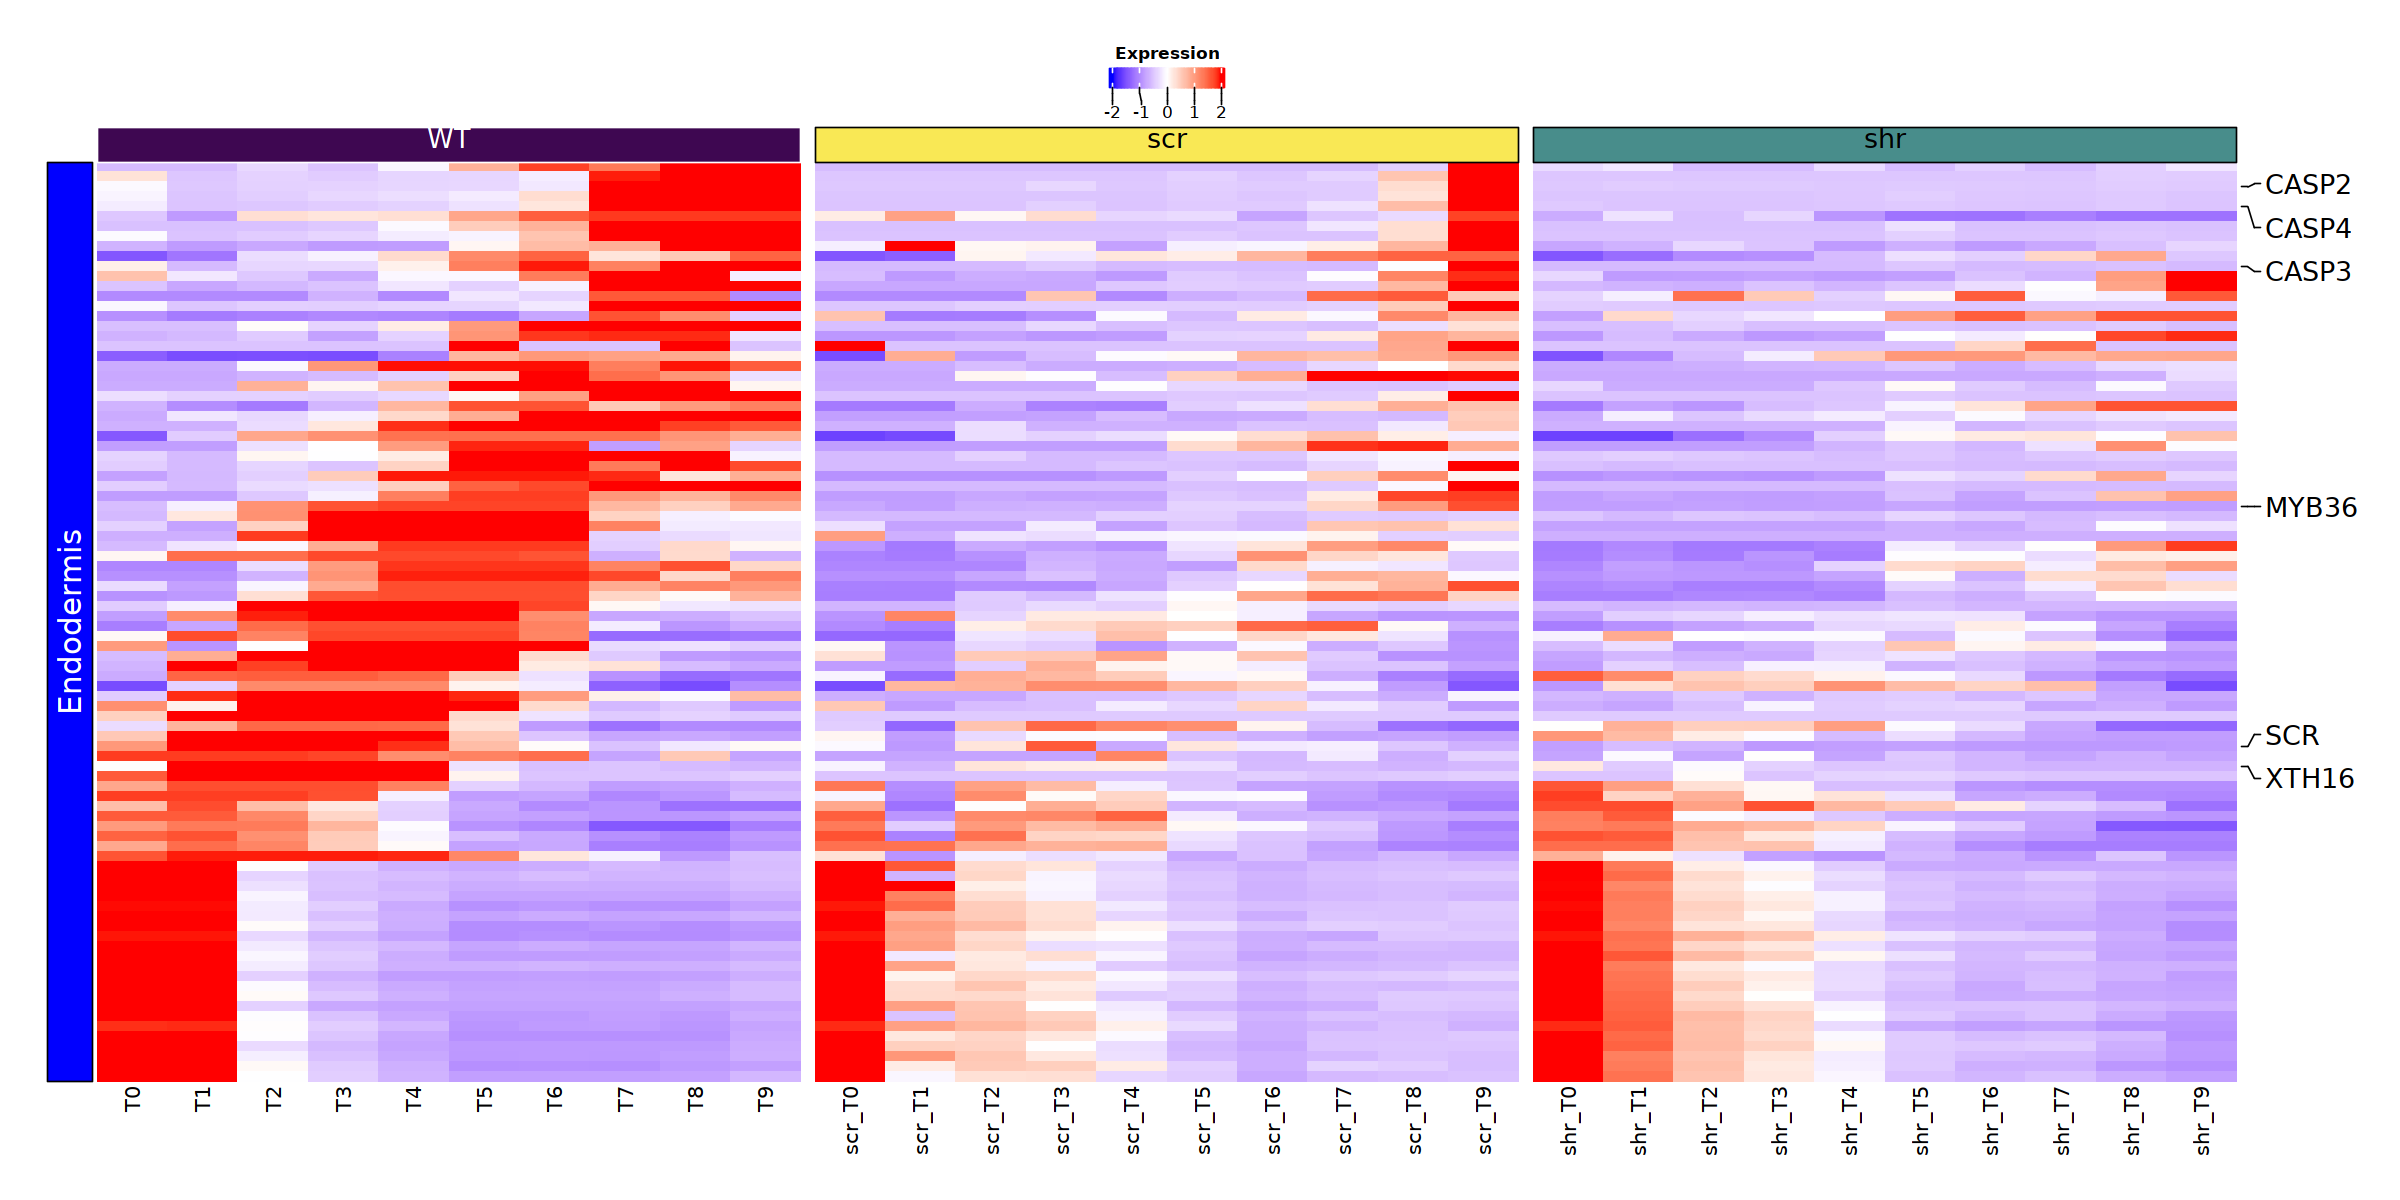

In [71]:
options(repr.plot.width=20, repr.plot.height=10)
Endo_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-2, 0, 2), 
                         c('blue','white','red')), 
                show_column_names = T,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
                   left_annotation=endo_sa,
                   right_annotation=endo_mark_anno,
               heatmap_legend_param = list(title_position="topcenter", title = "Expression", direction="horizontal"), 
                                     column_split = factor(c(rep("WT", 10), rep("scr", 10), rep("shr", 10)), levels=c("WT", "scr", "shr")),  
                    cluster_column_slices = FALSE, column_title_gp = gpar(fill = c("#3E0751", "#F9E855", "#488D8B"), font = c(1,3,3), col=c("white", "black", "black"), fontsize = 16), 
                   column_gap = unit(0.3, "cm"))

draw(Endo_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")


In [72]:
# cortex subset
Cor_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Cortex") & geno_trt=="WT")

In [73]:
# pseudobulk of each stage of cortex


  afm <- as.matrix(Cor_QC@assays$SCT@data)
  pooled_cortex <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Cor_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Cor_QC@meta.data$consensus.time.group==i)]
    pooled_cortex <- cbind(pooled_cortex, rowSums(m)/ncol(m))
  }



In [74]:
colnames(pooled_cortex) <- unique(Cor_QC@meta.data$consensus.time.group)

In [75]:
genes_to_plt_cortex <- read.csv("./supp_data/consensus_time_cortex_to_plot.csv")
genes_to_plt_cortex <- genes_to_plt_cortex$x

In [76]:
(cor_sub_m <- pooled_cortex[genes_to_plt_cortex, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

WT_cor_m <- cor_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT5G28060,2.53643481,3.2025137,0.96139871,0.79630121,0.69611259,0.50446119,0.42607623,0.459033428,0.467292246,0.32508480
AT2G27720,2.48226223,2.7928491,1.18620413,0.71866340,0.60698307,0.53450638,0.40508568,0.388953526,0.363147741,0.28571652
AT3G02080,2.26450380,2.6198624,0.65186314,0.59719124,0.48773937,0.45401283,0.32730161,0.289311509,0.345600354,0.27002549
AT5G16130,2.12879019,2.7304005,0.46030765,0.29711097,0.25581475,0.22814928,0.13252617,0.181407019,0.105511651,0.11308345
AT1G27400,2.56905599,3.1431596,0.67553956,0.34548031,0.29802316,0.19065356,0.15314356,0.143871484,0.169139307,0.11454810
AT5G45775,1.74833621,2.5353633,0.32991318,0.17577654,0.09241962,0.08773398,0.07734512,0.112312165,0.070067511,0.04881862
AT3G16080,2.31116854,2.8661727,0.57890304,0.25705931,0.29418740,0.17516917,0.12023742,0.158940570,0.144561547,0.06776022
AT3G45030,2.24188438,2.4468708,0.32783130,0.15141591,0.20489361,0.19119885,0.13934613,0.161231333,0.137924485,0.11308345
AT3G62530,1.48824347,2.0286492,0.18267614,0.04780325,0.07934190,0.02754927,0.02946580,0.024161955,0.041260433,0.03337242
AT3G13580,1.26122415,1.0649600,0.12487745,0.11151171,0.02772589,0.12061592,0.10497798,0.065613576,0.074805817,0.03934783


In [77]:
# annotation bar for consensus time
library(RColorBrewer)
col_fun <- brewer.pal(10,"Spectral")

names(col_fun) <- c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")
col_fun

ha = HeatmapAnnotation(`Consensus Time Group` = c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"), col = list(`Consensus Time Group` = col_fun), show_legend = F)

T0        T1        T2        T3        T4        T5        T6        T7 
"#9E0142" "#D53E4F" "#F46D43" "#FDAE61" "#FEE08B" "#E6F598" "#ABDDA4" "#66C2A5" 
       T8        T9 
"#3288BD" "#5E4FA2"

In [78]:
# quantile normalize

mat = cor_sub_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

In [79]:
# side annotation to match cortex colors

cortex_sa = rowAnnotation(foo = anno_block(gp = gpar(fill = "#82B6FF"),
        labels = c("Cortex"), 
        labels_gp = gpar(col = "black", fontsize = 18)))

In [80]:
# genes to label on side of heatmap for cortex

(cor_mat_for_mark <- data.frame(mat2) %>% 
 rownames_to_column("gene") %>%
 left_join(feature_names) %>% 
 mutate(index=dplyr::row_number()) %>%
select(Name, index) %>%
filter(Name %in% c("AT1G17285", "AT5G02000", "C/VIF2", "CYP72A15", "PER56", "PER69", "AT4G09760")))

Joining, by = "gene"



Name,index
<chr>,<int>
AT1G17285,23
AT5G02000,34
C/VIF2,64
CYP72A15,71
PER56,76
AT4G09760,81


In [81]:
# at - index of genes you want to mark
# labels - Names to show

cor_mark_anno = rowAnnotation(foo = anno_mark(at = cor_mat_for_mark$index, labels = cor_mat_for_mark$Name, labels_gp = gpar(col = "black", fontsize = 16)))

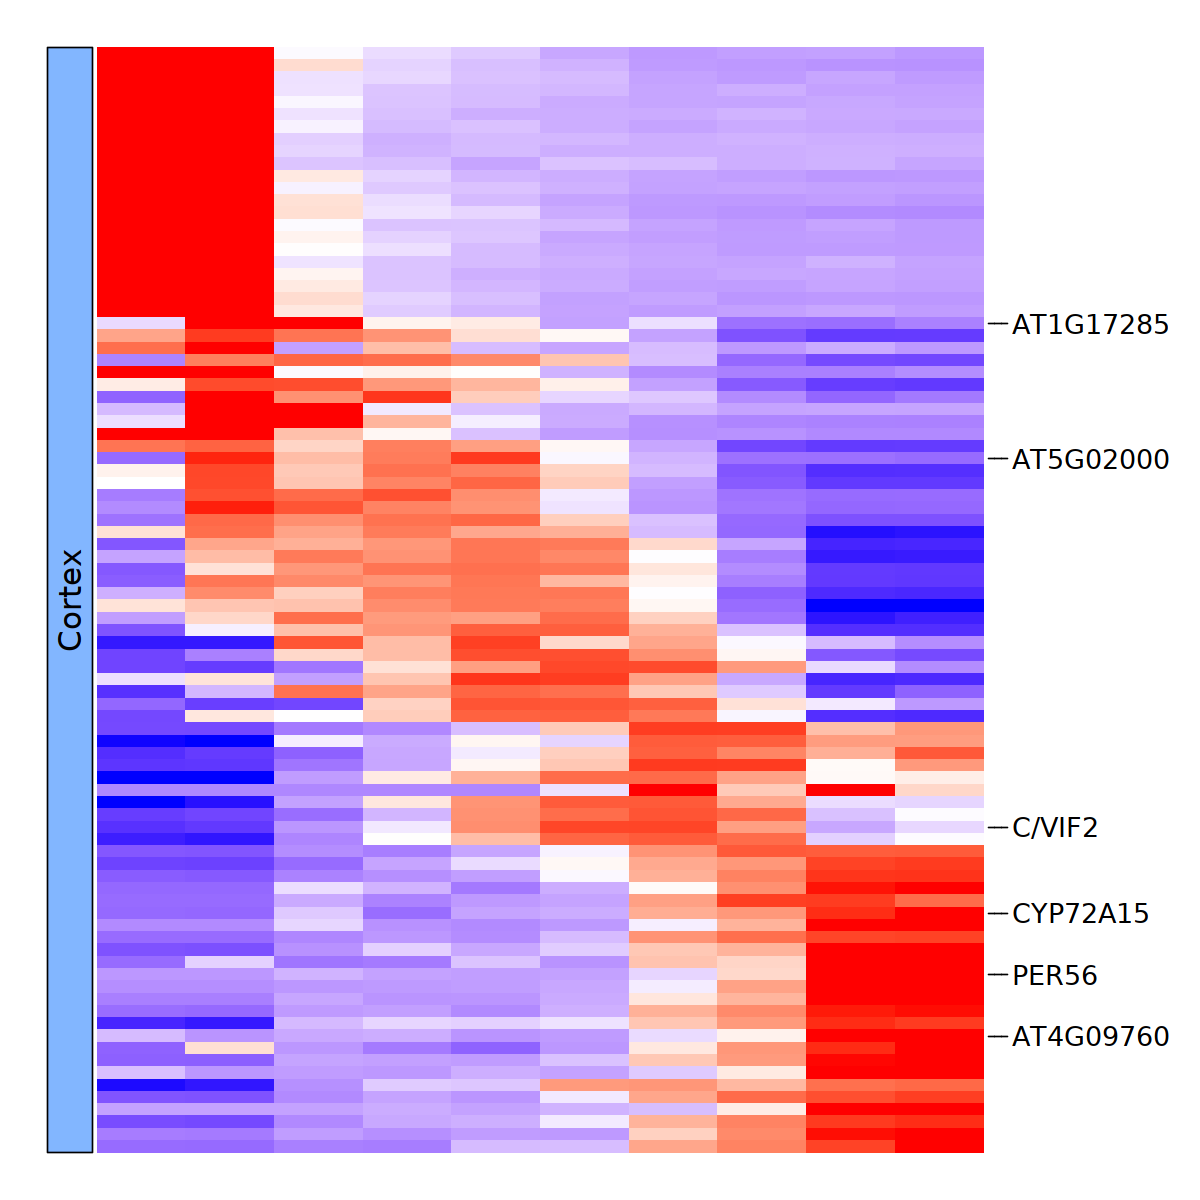

In [84]:
options(repr.plot.width=10, repr.plot.height=10)
Cortex_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-1.5, 0, 1.5), 
                         c('blue','white','red')), 
                show_column_names = F,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
        show_heatmap_legend = F, 
        left_annotation=cortex_sa, 
        right_annotation=cor_mark_anno)

draw(Cortex_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")



In [85]:
# text annotation for consensus time

ht = columnAnnotation(foo = anno_text(c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"), rot = 0, just = "center", gp = gpar(fontsize = 16)))

In [86]:
# subset for mutant layer
COR_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Endodermis", "Cortex") & geno_trt=="shr")

In [87]:
COR_QC

An object of class Seurat 
160595 features across 1731 samples within 7 assays 
Active assay: integrated (17978 features, 17978 variable features)
 6 other assays present: RNA, SCT, spliced_RNA, unspliced_RNA, spliced_SCT, unspliced_SCT
 5 dimensional reductions calculated: pca, umap, umap_50, umap_3D, umap_2D

In [88]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(COR_QC@assays$SCT@data)
  pooled_cor <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(COR_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(COR_QC@meta.data$consensus.time.group==i)]
    pooled_cor <- cbind(pooled_cor, rowSums(m)/ncol(m))
  }



In [89]:
colnames(pooled_cor) <- unique(COR_QC@meta.data$consensus.time.group)

In [90]:
(cor_sub_m <- pooled_cor[genes_to_plt_cortex, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

colnames(cor_sub_m) <- c("shr_T0", "shr_T1", "shr_T2", "shr_T3", "shr_T4", "shr_T5", "shr_T6", "shr_T7", "shr_T8", "shr_T9")
shr_cor_m <- cor_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT5G28060,2.98222357,2.6385529,2.0594894,1.8102979,1.55135000,1.13923667,1.04136169,1.08764748,0.765929820,0.45425313
AT2G27720,2.65309851,2.1493694,1.6541850,1.3407341,0.99005552,0.62222660,0.50176488,0.59750125,0.468707830,0.20815137
AT3G02080,2.69677585,2.1957580,1.5969127,1.4047933,1.17660268,0.87750788,0.87721279,0.94045365,0.713077840,0.51242283
AT5G16130,2.56138349,1.6768468,0.8201194,0.6021988,0.37786116,0.20965809,0.14024332,0.14737379,0.101413845,0.05152610
AT1G27400,2.83445798,1.8918363,1.0784647,0.8767472,0.54439191,0.38953016,0.23817557,0.21391595,0.153856977,0.03340468
AT5G45775,2.11823149,1.2280986,0.5249570,0.3946736,0.26922230,0.11136776,0.07333174,0.10120362,0.063017759,0.05010703
AT3G16080,2.56268037,1.6418654,0.7704087,0.6244504,0.26951842,0.17271459,0.09452373,0.10814371,0.093427694,0.06334332
AT3G45030,2.36768484,1.5089340,0.5129098,0.2923595,0.12803443,0.06431263,0.05252582,0.08752161,0.062068313,0.02505351
AT3G62530,1.51436250,0.7810805,0.2515686,0.1053211,0.04956381,0.05420098,0.05307744,0.05740491,0.056328778,0.04317493
AT3G13580,1.18772131,0.8208278,0.4736477,0.2264985,0.15850520,0.10125612,0.07278012,0.09541136,0.090771855,0.04664098


In [91]:
# subset for mutant layer
COR_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Endodermis", "Cortex") & geno_trt=="scr")

In [92]:
COR_QC

An object of class Seurat 
160595 features across 952 samples within 7 assays 
Active assay: integrated (17978 features, 17978 variable features)
 6 other assays present: RNA, SCT, spliced_RNA, unspliced_RNA, spliced_SCT, unspliced_SCT
 5 dimensional reductions calculated: pca, umap, umap_50, umap_3D, umap_2D

In [94]:
table(COR_QC$consensus.time.group)


 T0  T1  T2  T3  T4  T5  T6  T7  T8  T9 
 13   1  19  22  30 112 169 100 327 159 

In [95]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(COR_QC@assays$SCT@data)
  pooled_cor <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(COR_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(COR_QC@meta.data$consensus.time.group==i)]
      if(length(which(COR_QC@meta.data$consensus.time.group==i))>1){
        pooled_cor <- cbind(pooled_cor, rowSums(m)/ncol(m))          
      } else {
        pooled_cor <- cbind(pooled_cor, m)   
      }

  }


In [96]:
colnames(pooled_cor) <- unique(COR_QC@meta.data$consensus.time.group)

In [97]:
(cor_sub_m <- pooled_cor[genes_to_plt_cortex, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

colnames(cor_sub_m) <- c("scr_T0", "scr_T1", "scr_T2", "scr_T3", "scr_T4", "scr_T5", "scr_T6", "scr_T7", "scr_T8", "scr_T9")
scr_cor_m <- cor_sub_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
AT5G28060,2.80766940,2.197225,1.33176581,1.03441829,1.21200461,0.77712372,0.53042909,0.632260766,0.68469130,0.717888253
AT2G27720,2.88706392,1.945910,1.21205980,1.06778053,0.78345314,0.64838057,0.36914499,0.520166950,0.59801069,0.687134979
AT3G02080,2.72073734,1.945910,1.06125463,0.63255401,0.95425194,0.51087161,0.49202885,0.511004043,0.56194028,0.706241438
AT5G16130,2.37274866,1.386294,0.83632996,0.54338771,0.28511107,0.18881933,0.11793710,0.145039748,0.16874242,0.224887420
AT1G27400,2.78728393,1.098612,0.84915958,0.54632128,0.35049969,0.22975654,0.13093842,0.206245164,0.18074033,0.206688064
AT5G45775,1.85816522,0.000000,0.36761665,0.38878783,0.11552453,0.15016949,0.05811742,0.108026728,0.13622629,0.198068278
AT3G16080,2.37625646,0.000000,0.78900442,0.33349713,0.26766947,0.11712215,0.09742978,0.117835021,0.15038191,0.141952368
AT3G45030,2.20706557,1.098612,0.32833288,0.19439391,0.29077438,0.18157888,0.11623484,0.186628579,0.16046092,0.158092758
AT3G62530,1.56944076,0.000000,0.42263600,0.14445699,0.11552453,0.05056215,0.07382633,0.052574954,0.08922889,0.054863090
AT3G13580,1.46202963,1.098612,0.26156912,0.36500382,0.30428988,0.12120769,0.10083430,0.129998974,0.15526575,0.184990029


In [98]:
combined_cor_m <- cbind(WT_cor_m, scr_cor_m, shr_cor_m)

In [99]:
combined_cor_m

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,⋯,shr_T0,shr_T1,shr_T2,shr_T3,shr_T4,shr_T5,shr_T6,shr_T7,shr_T8,shr_T9
AT5G28060,2.53643481,3.2025137,0.96139871,0.79630121,0.69611259,0.50446119,0.42607623,0.459033428,0.467292246,0.32508480,⋯,2.98222357,2.6385529,2.0594894,1.8102979,1.55135000,1.13923667,1.04136169,1.08764748,0.765929820,0.45425313
AT2G27720,2.48226223,2.7928491,1.18620413,0.71866340,0.60698307,0.53450638,0.40508568,0.388953526,0.363147741,0.28571652,⋯,2.65309851,2.1493694,1.6541850,1.3407341,0.99005552,0.62222660,0.50176488,0.59750125,0.468707830,0.20815137
AT3G02080,2.26450380,2.6198624,0.65186314,0.59719124,0.48773937,0.45401283,0.32730161,0.289311509,0.345600354,0.27002549,⋯,2.69677585,2.1957580,1.5969127,1.4047933,1.17660268,0.87750788,0.87721279,0.94045365,0.713077840,0.51242283
AT5G16130,2.12879019,2.7304005,0.46030765,0.29711097,0.25581475,0.22814928,0.13252617,0.181407019,0.105511651,0.11308345,⋯,2.56138349,1.6768468,0.8201194,0.6021988,0.37786116,0.20965809,0.14024332,0.14737379,0.101413845,0.05152610
AT1G27400,2.56905599,3.1431596,0.67553956,0.34548031,0.29802316,0.19065356,0.15314356,0.143871484,0.169139307,0.11454810,⋯,2.83445798,1.8918363,1.0784647,0.8767472,0.54439191,0.38953016,0.23817557,0.21391595,0.153856977,0.03340468
AT5G45775,1.74833621,2.5353633,0.32991318,0.17577654,0.09241962,0.08773398,0.07734512,0.112312165,0.070067511,0.04881862,⋯,2.11823149,1.2280986,0.5249570,0.3946736,0.26922230,0.11136776,0.07333174,0.10120362,0.063017759,0.05010703
AT3G16080,2.31116854,2.8661727,0.57890304,0.25705931,0.29418740,0.17516917,0.12023742,0.158940570,0.144561547,0.06776022,⋯,2.56268037,1.6418654,0.7704087,0.6244504,0.26951842,0.17271459,0.09452373,0.10814371,0.093427694,0.06334332
AT3G45030,2.24188438,2.4468708,0.32783130,0.15141591,0.20489361,0.19119885,0.13934613,0.161231333,0.137924485,0.11308345,⋯,2.36768484,1.5089340,0.5129098,0.2923595,0.12803443,0.06431263,0.05252582,0.08752161,0.062068313,0.02505351
AT3G62530,1.48824347,2.0286492,0.18267614,0.04780325,0.07934190,0.02754927,0.02946580,0.024161955,0.041260433,0.03337242,⋯,1.51436250,0.7810805,0.2515686,0.1053211,0.04956381,0.05420098,0.05307744,0.05740491,0.056328778,0.04317493
AT3G13580,1.26122415,1.0649600,0.12487745,0.11151171,0.02772589,0.12061592,0.10497798,0.065613576,0.074805817,0.03934783,⋯,1.18772131,0.8208278,0.4736477,0.2264985,0.15850520,0.10125612,0.07278012,0.09541136,0.090771855,0.04664098


In [100]:
# quantile normalize

mat = combined_cor_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

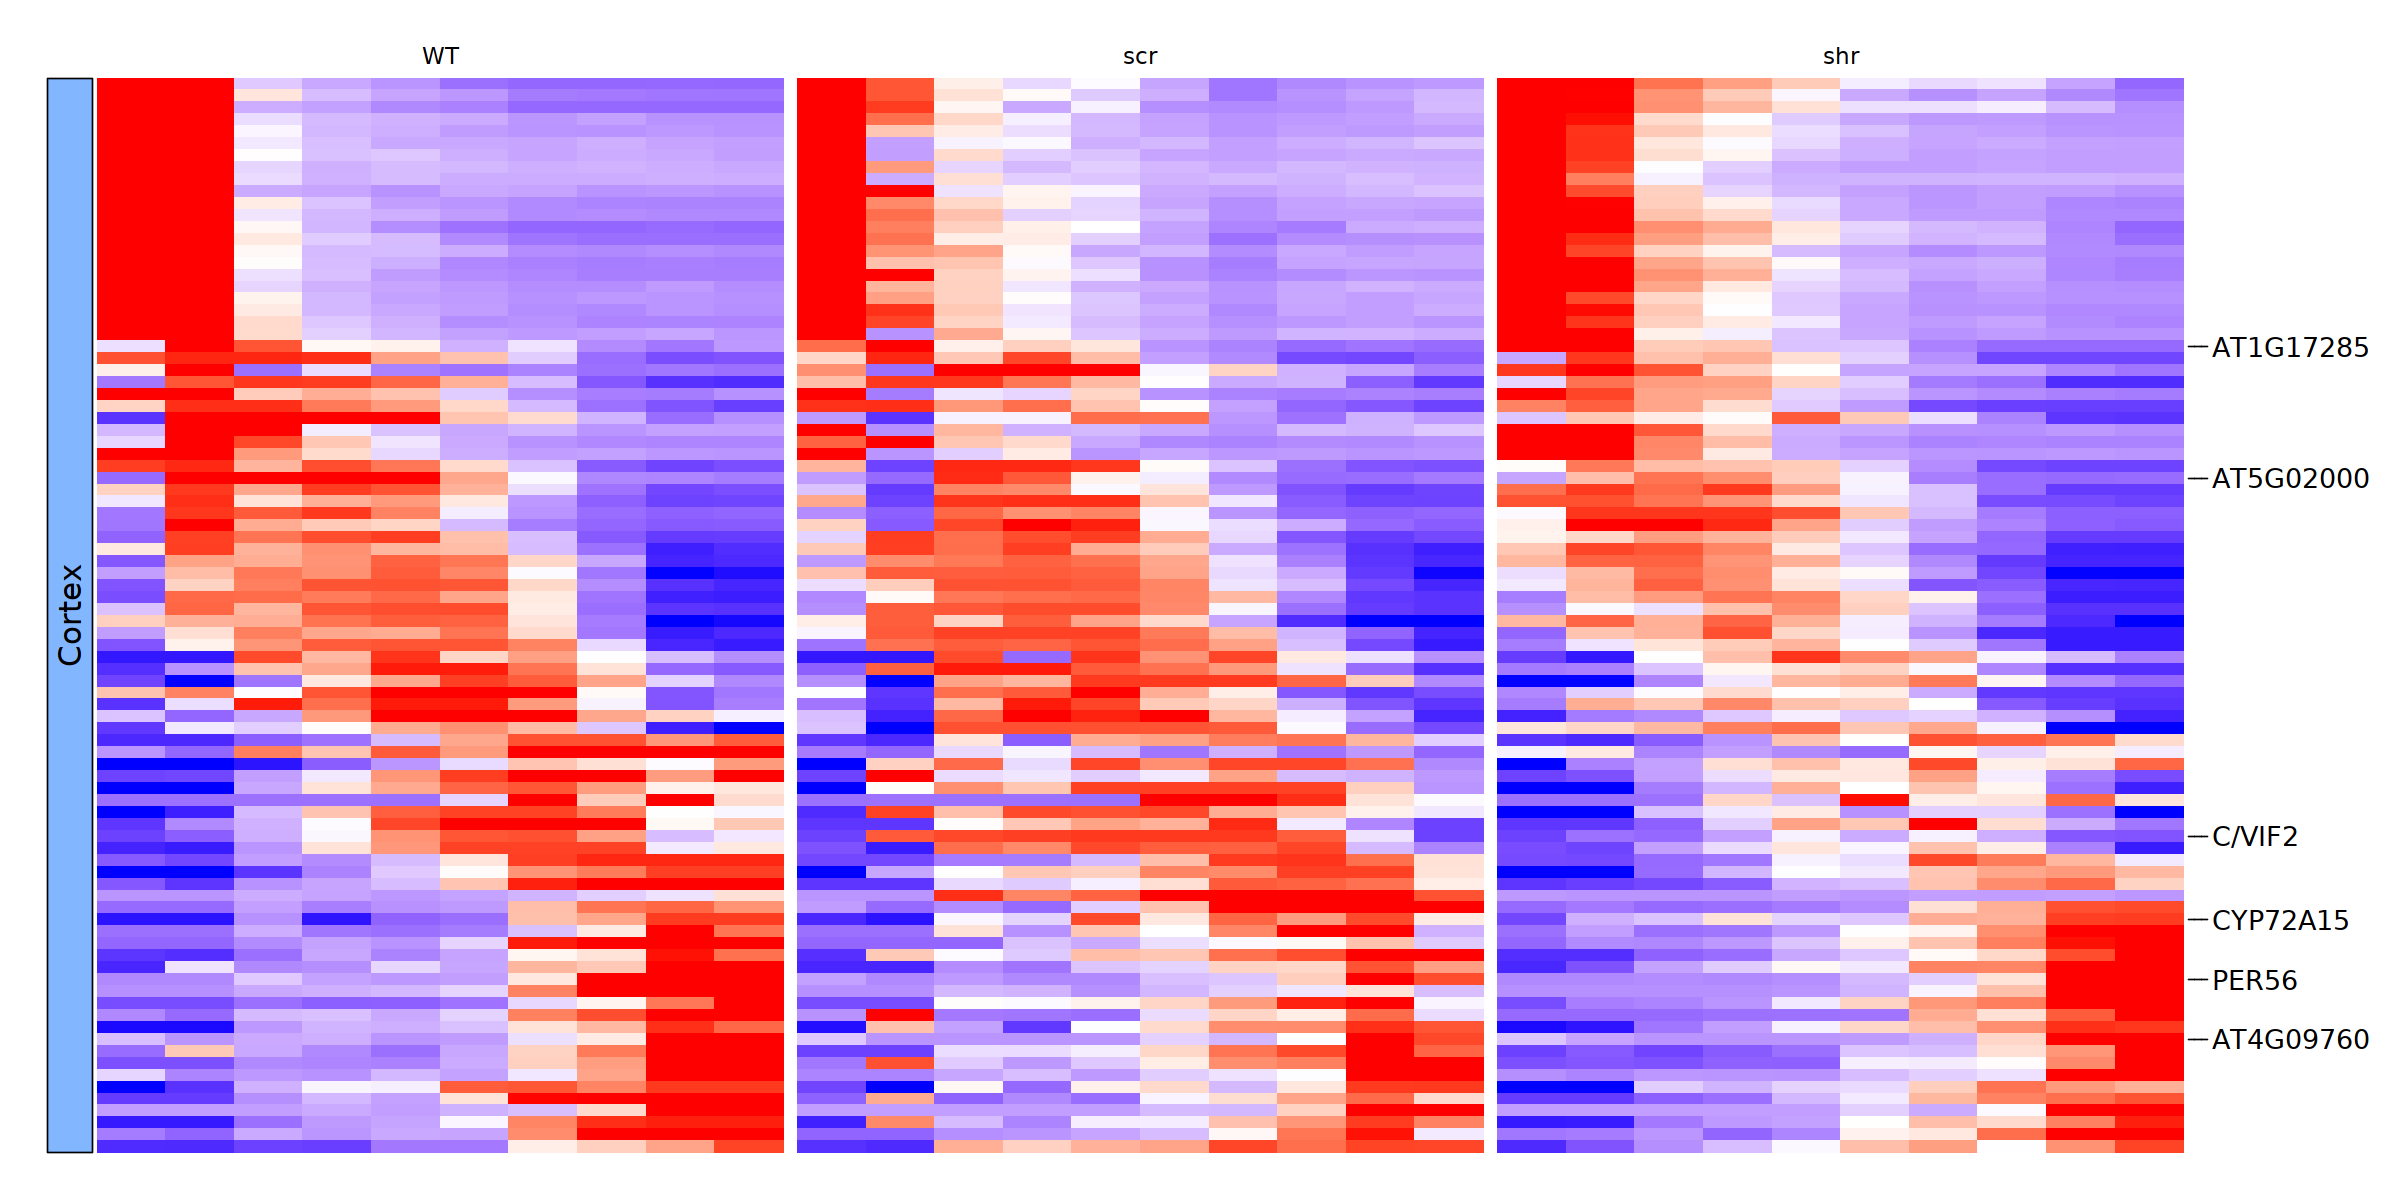

In [101]:
# ['#d8b365','#f5f5f5','#5ab4ac']

Cortex_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-1.5, 0, 1.5), 
                         c('blue','white','red')), 
                show_column_names = F,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
        show_heatmap_legend = F, 
        left_annotation=cortex_sa, 
        right_annotation=cor_mark_anno, 
                    column_split = factor(c(rep("WT", 10), rep("scr", 10), rep("shr", 10)), levels=c("WT", "scr", "shr")),  
                    cluster_column_slices = FALSE, column_gap = unit(0.3, "cm"))



options(repr.plot.width=20, repr.plot.height=10)

draw(Cortex_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")


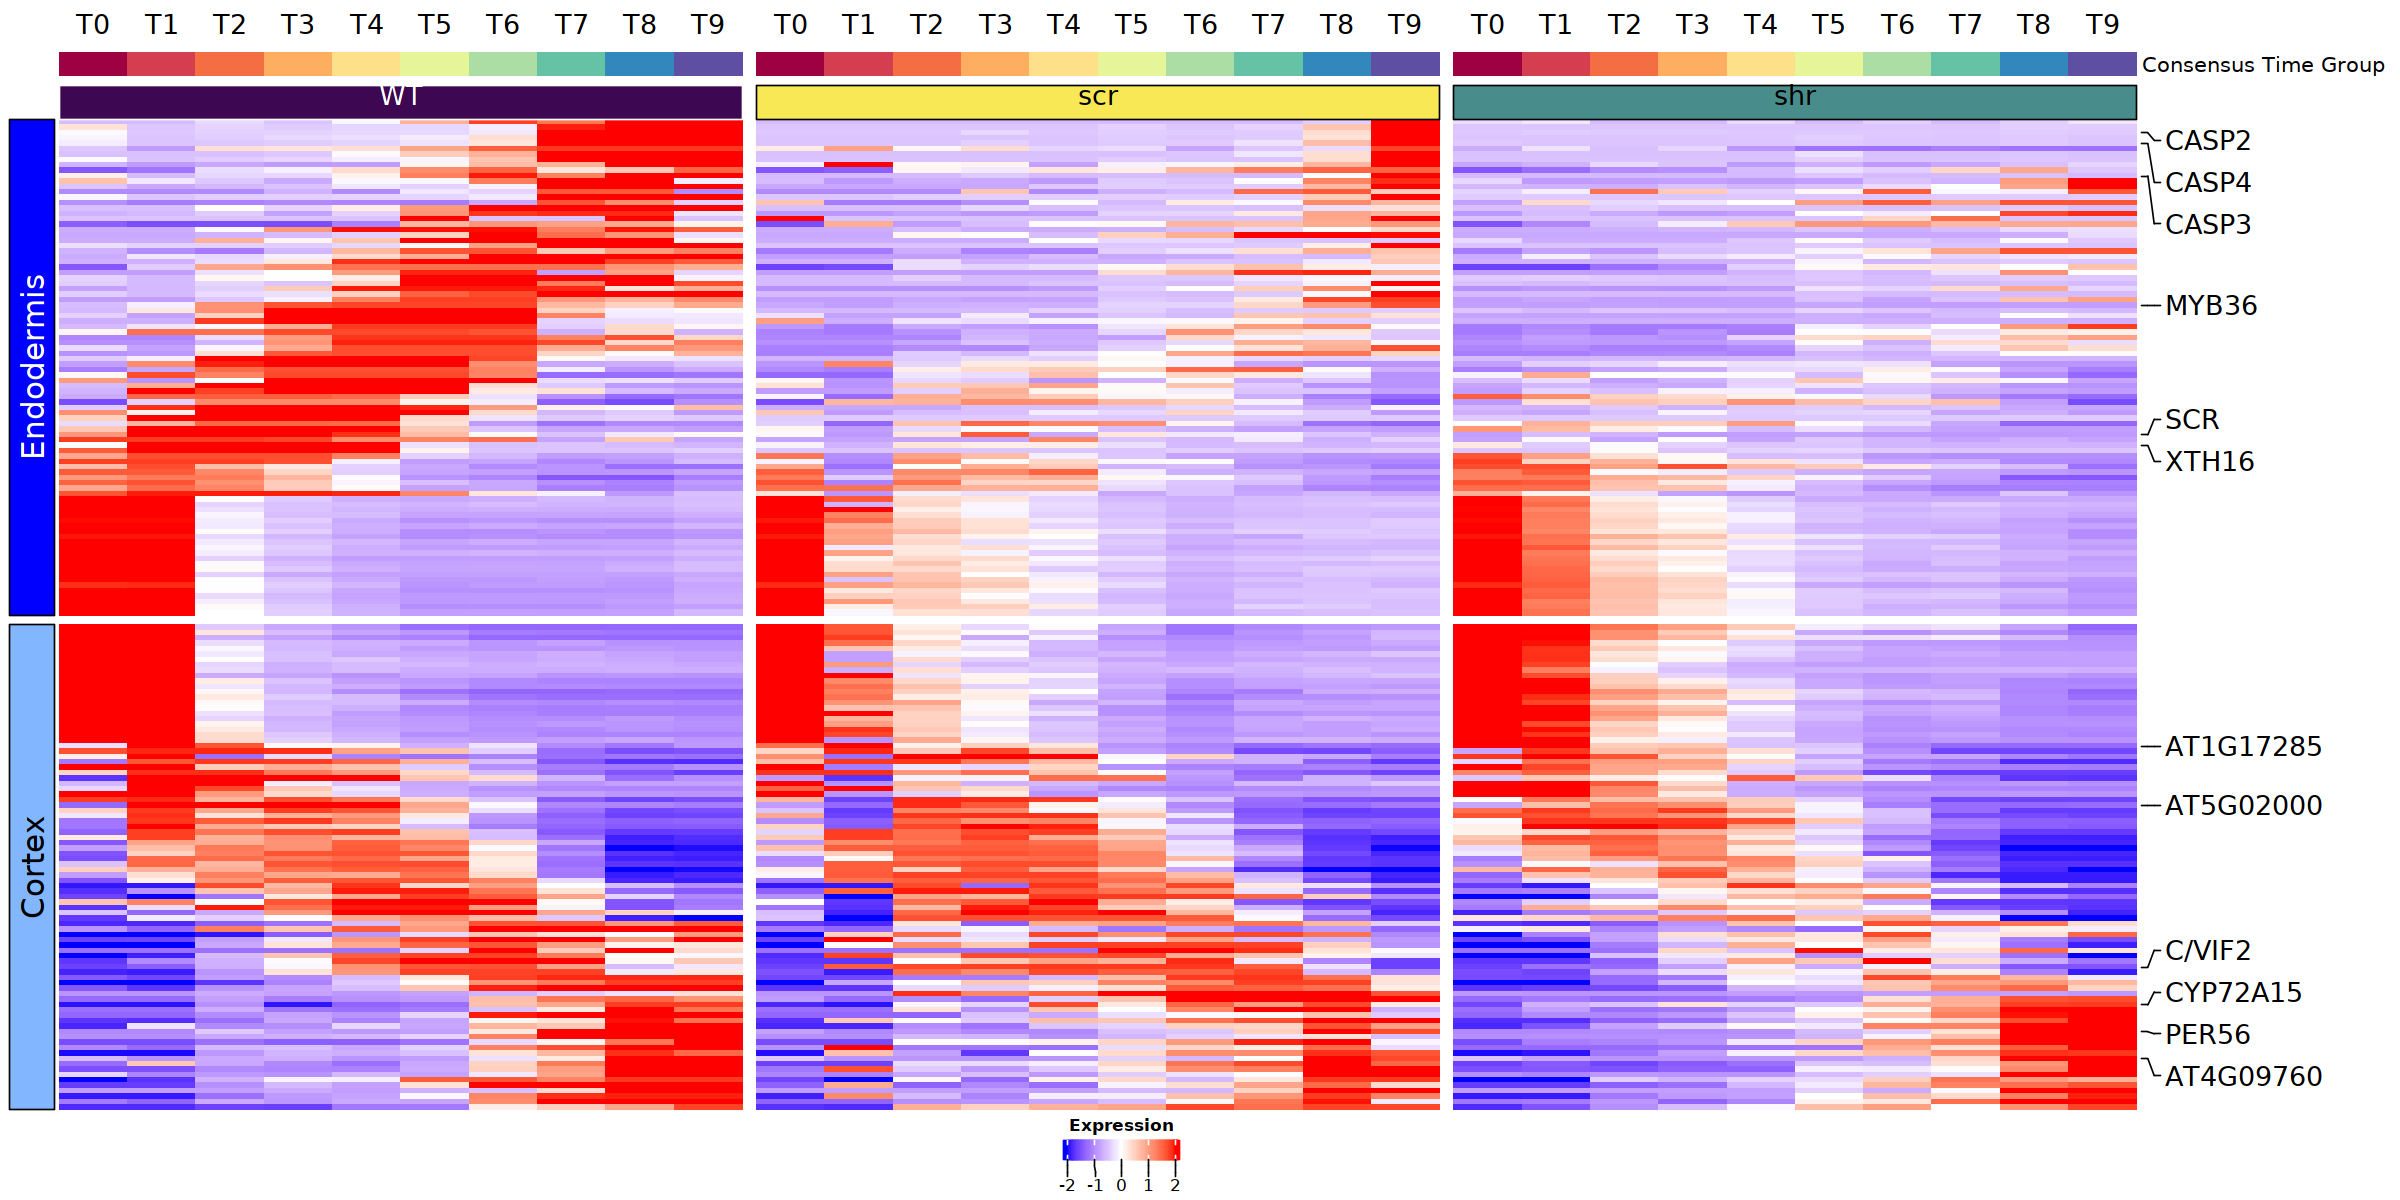

In [102]:
options(repr.plot.width=20, repr.plot.height=10)


ht_list = ht %v% ha %v% Endo_hm %v% Cortex_hm

draw(ht_list, ht_gap = unit(0.2, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom")
# grab heatmap as a grob to arrange in cowplot
hm_final <- grid.grabExpr(draw(ht_list, ht_gap = unit(0.2, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom"))## bottom, left, top and right



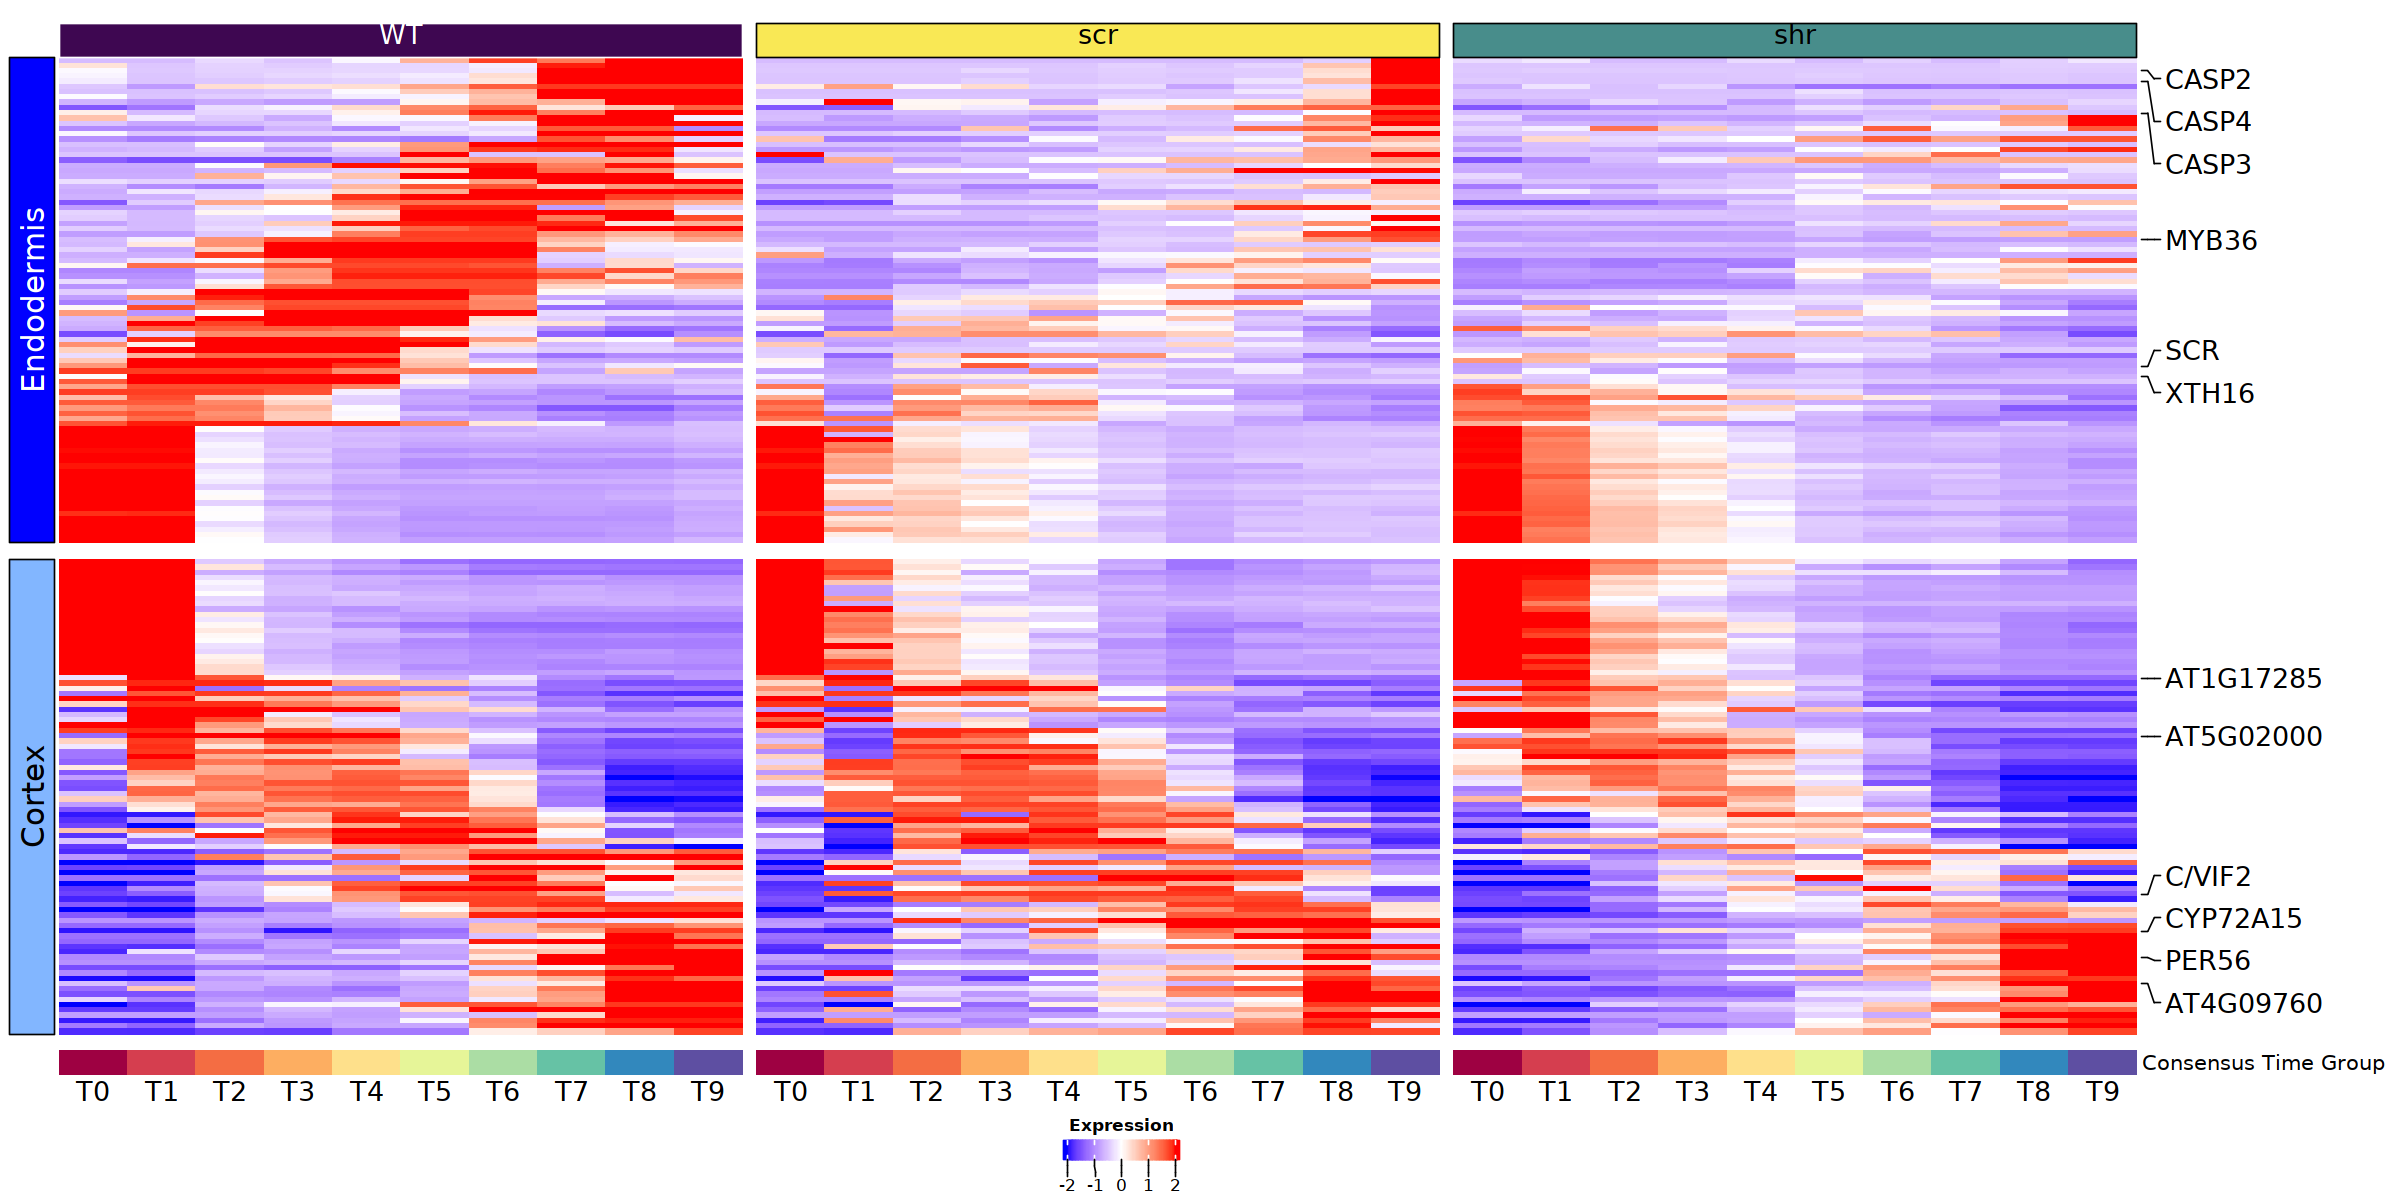

In [118]:
options(repr.plot.width=20, repr.plot.height=10)


ht_list =  Endo_hm %v% Cortex_hm  %v% ha %v% ht

draw(ht_list, ht_gap = unit(0.35, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom")
# grab heatmap as a grob to arrange in cowplot
hm_final <- grid.grabExpr(draw(ht_list, ht_gap = unit(0.35, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom"))## bottom, left, top and right



In [119]:
# output heatmap as pdf

pdf("./supp_data/WT_scr_shr_Ground_tissue_heatmap.pdf", width = 20, height = 10)
draw(ht_list, ht_gap = unit(0.35, "cm"), padding = unit(c(0, 2, 5, 10), "mm"), heatmap_legend_side = "bottom")
dev.off()

png 
  2

In [120]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/seu3/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] RColorBrewer_1.1-2   future_1.20.1        ggrepel_0.8.2       
 [4] GeneOverlap_1.26.0   circlize_0.4.12      ComplexHeatmap_2.6.2
 [7] cowplot_1.1.0        Seurat_3.1.5         forcats_0.5.0       
[10] stringr_1.4.0        dplyr_1.0.2          purrr_0.3.4         
[13] readr_1.